In [127]:
library(tidyverse)
library(cowplot)
options(repr.plot.width=4, repr.plot.height=3)

## Generate Figure 1a

Figure 1A shows how the overdispersion effects the results of our $R^2$ statistic. To do this I generated 1000 simulations under a neutral evolutionary model using a simulation framework I developed in the julia programming language: [CancerSeqSim.jl](https://github.com/marcjwilliams1/CancerSeqSim.jl)

In [128]:
#read in data
dfsim <- read.csv("data/simulation-data.csv")

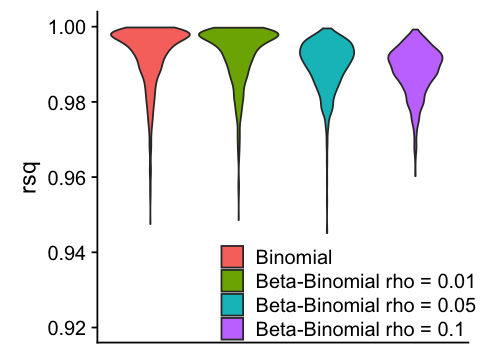

In [129]:
#plot violin plots of distribution of R^2 under different overdispersion parametes
dfsim$sampling <- factor(dfsim$sampling, 
                    levels = c("Binomial",
                                "Beta-Binomial rho = 0.01",
                                "Beta-Binomial rho = 0.05",
                                "Beta-Binomial rho = 0.1"))

gsim <- ggplot(dfsim, aes(x = sampling, fill = sampling, y = rsq)) +
geom_violin() +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
        guides(fill=guide_legend(title="")) +
theme(legend.position = c(0.3, 0.2)) + ylim(c(0.92, 1.0))
gsim

## Measuring overdispersion using MCMC

To estimate the overdispersion in our data we used Markov Chain Monte Carlo. The code to implement this is in the R/ folder in this repo.

To test the method I'll first confirm that the overdispersion parameter $\rho$ can be recovered from a simulated dataset (again using [CancerSeqSim.jl](https://github.com/marcjwilliams1/CancerSeqSim.jl)) where the ground truth is known and is equal to 0.02.

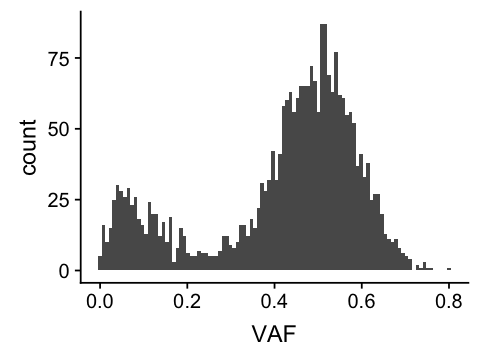

In [130]:
df <- read.csv("data/onesimulation.csv")

ggplot(df, aes(x = VAF)) +
geom_histogram(bins = 100)

In [131]:
source("R/mcmc.R")
options(warn=-1)

getmcmcresults <- function(df, id, lims = c(0.4,0.6), nsamps = 3000){
  plims <- matrix(nrow=2,ncol=2, data=c(lims[1],lims[2], 0.0,0.1), byrow=T)
  initp = c(0.5,0.05)
  sc = c(1.0,1.0)
  df1 <- df[df$VAF > lims[1] & df$VAF < lims[2],]
  p.log=function(x){ LLbetabin(df1, x) + log( prior(x,plims)) }
  post <- MCMC(p.log, n=nsamps, init=initp, scale=sc, adapt=TRUE, acc.rate=0.234)
  ggplots <- makeplots(post$samples, df, median(df$DP), lims)
  return(list(ggplots, post))
}

x <- getmcmcresults(df, "simulation", lims = c(0.3, 0.8), nsamps = 10000);

  generate 10000 samples 


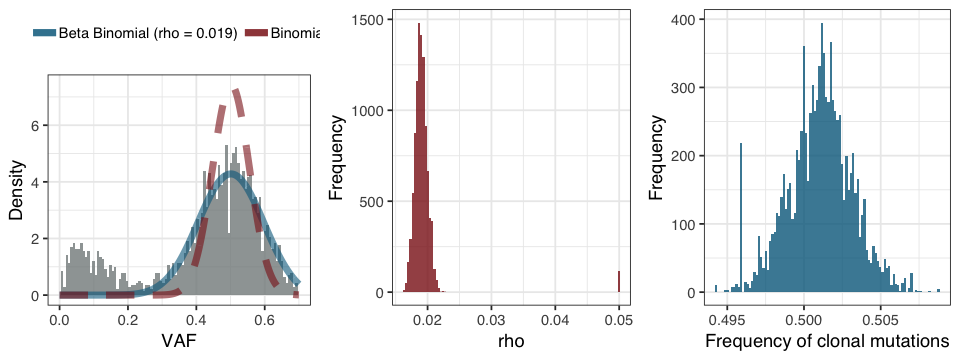

In [132]:
# Left plot is the fitted distributions and the right plot is the posterior distribution for rho
options(repr.plot.width=8, repr.plot.height=3)

plot_grid(x[[1]][[1]] + theme(legend.position = "top"), 
          x[[1]][[2]],
         x[[1]][[3]], ncol = 3)

As can be seen the method performs well and the posterior distribution for $\rho$ is centred around the true value, and the mean of the cluster of clonal mutations is at approximately 0.5 as expected. We'll now move on to some real data to measure the over-dispersion in this data.

In [133]:
df <- read.table("data/WA_colon.txt", header = T)
WAcolon <- getmcmcresults(df, "simulation", lims = c(0.3, 0.8), nsamps = 10000)

  generate 10000 samples 


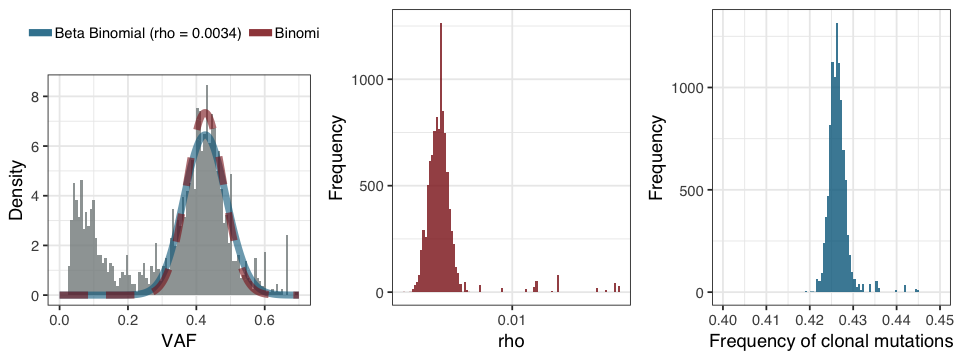

In [134]:
plot_grid(WAcolon[[1]][[1]] + theme(legend.position = "top"), 
          WAcolon[[1]][[2]] + scale_x_log10(),
          WAcolon[[1]][[3]] + xlim(c(0.4, 0.45)), ncol = 3)

In [135]:
df <- read.table("data/pfg144.txt", header = T)
gastric <- getmcmcresults(df, "simulation", lims = c(0.22, 0.5), nsamps = 10000)

  generate 10000 samples 


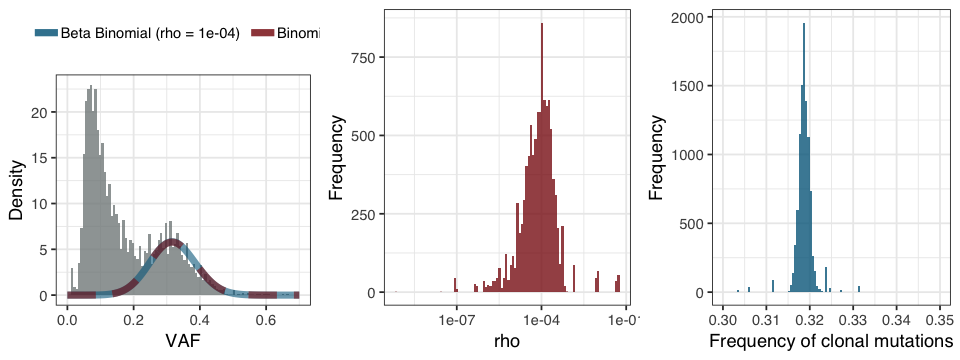

In [136]:
plot_grid(gastric[[1]][[1]] + theme(legend.position = "top"), 
          gastric[[1]][[2]] + scale_x_log10(),
          gastric[[1]][[3]] + xlim(c(0.3, 0.35)), ncol = 3)

The overdispersion we measure is considerable lower than that proposed by Balaparya and De. $\rho = 0.0001-0.003$ compared to $\rho=0.1$ proposed by Balaparya and De.

### Combine plots together

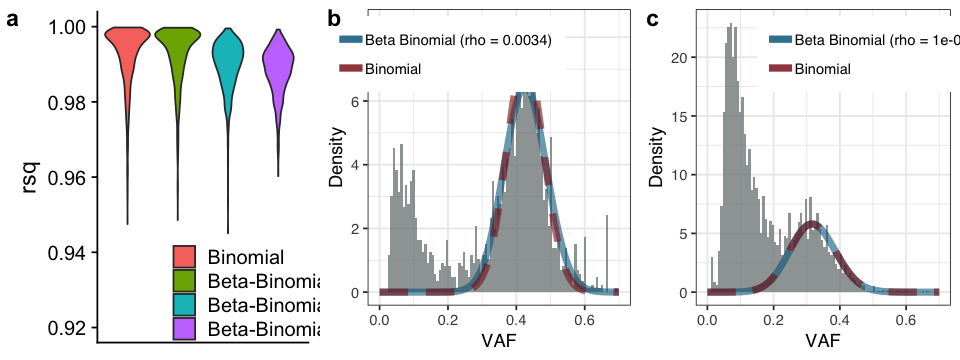

In [137]:
finalplot <- plot_grid(gsim,
          WAcolon[[1]][[1]] + theme(legend.position = c(0.3, 0.85)),
          gastric[[1]][[1]] + theme(legend.position = c(0.7, 0.85)), ncol = 3, labels = c("a", "b", "c"))

save_plot("Figure1.pdf", finalplot, base_height = 5, base_width = 12)

finalplot